In [43]:
import argparse
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

import torch
from torch import nn

from dataloader import mnist_usps,mnist_Rmnist
from module import Encoder, AdversarialNetwork, DFC, adv_loss
from eval import predict, cluster_accuracy, balance
from utils import set_seed, AverageMeter, target_distribution, aff, inv_lr_scheduler


# parser.add_argument("--bs", type=int, default=512)
# parser.add_argument("--k", type=int, default=10)
# parser.add_argument("--lr", type=float, default=1e-2)
# parser.add_argument("--iters", type=int, default=20000)
# parser.add_argument("--test_interval", type=int, default=5000)
# parser.add_argument("--adv_mult", type=float, default=10.0)
# parser.add_argument("--coeff_fair", type=float, default=1.0)
# parser.add_argument("--coeff_par", type=float, default=1.0)
# parser.add_argument("--gpu", type=int, default=0)
# parser.add_argument("--seed", type=int, default=2019)
# parser.add_argument("--corrupted",type=float, default=0)
# parser.add_argument("--corrupted_set",type=int, default=0)
# parser.add_argument("--dataset",type=str, default="usps")
# args = parser.parse_args()
class Args:
    bs = 512
    k = 10
    lr = 1e-2
    iters = 20000
    test_interval = 5000
    adv_mult = 10.0
    coeff_fair = 1.0
    coeff_par = 1.0
    gpu = 0
    seed = 2019
    corrupted = 0
    corrupted_set = 0
    dataset = "usps"
    divergence = "KL"

args = Args()

def validation(path0,path1,args):
    set_seed(args.seed)
    torch.cuda.set_device(args.gpu)

    encoder = Encoder().cuda()
    encoder_group_0 = Encoder().cuda()
    encoder_group_1 = Encoder().cuda()

    dfc = DFC(cluster_number=args.k, hidden_dimension=64).cuda()
    dfc_group_0 = DFC(cluster_number=args.k, hidden_dimension=64).cuda()
    dfc_group_1 = DFC(cluster_number=args.k, hidden_dimension=64).cuda()

    critic = AdversarialNetwork(in_feature=args.k,
                                hidden_size=32,
                                max_iter=args.iters,
                                lr_mult=args.adv_mult).cuda()

    # loading in trained values
    print("loading in networks")
    critic.load_state_dict(torch.load("./save/"+ path0 + "critic_" + path1))
    encoder.load_state_dict(torch.load("./save/"+ path0 + "encoder_" + path1))
    dfc.load_state_dict(torch.load("./save/"+ path0 + "dfc_" + path1))
    
    
    # encoder and clustering model trained by DEC
    encoder_group_0.load_state_dict(torch.load("./save/encoder_mnist.pth"))
    dfc_group_0.load_state_dict(torch.load("./save/dec_mnist.pth"))
    #dataset dependend variables
    if args.dataset == "usps":
        encoder_group_1.load_state_dict(torch.load("./save/encoder_usps.pth"))
        dfc_group_1.load_state_dict(torch.load("./save/dec_usps.pth"))
        centers = np.loadtxt("./save/centers.txt")
        #data loader
        data_loader = mnist_usps(args)

    elif args.dataset == "Rmnist":
        encoder_group_1.load_state_dict(torch.load("./save/encoder_Rmnist.pth"))
        centers = np.loadtxt("./save/centers_Rmnist.txt")
        #data loader
        data_loader = mnist_Rmnist(args)
    print("loaded in the networks")
    
    print("evalutating")
    predicted, labels = predict(data_loader, encoder, dfc)
    predicted, labels = predicted.cpu().numpy(), labels.numpy()
    _, accuracy = cluster_accuracy(predicted, labels, 10)
    nmi = normalized_mutual_info_score(labels, predicted, average_method="arithmetic")
    bal, en_0, en_1 = balance(predicted, 60000)
    print("Acc:{:2.3f};"
          "NMI:{:1.3f};"
          "Bal:{:1.3f};"
          "En:{:1.3f}/{:1.3f};".format(accuracy, nmi, bal, en_0,en_1))
    return (accuracy, nmi, bal, en_0,en_1)
args.dataset = "Rmnist"
results= []
results += [validation("mnist_Rmnist_cor_0.6/","Cor0.6_mnist4999.pth",args)]
results += [validation("mnist_Rmnist_cor_0.9/","Cor0.9_mnist4999.pth",args)]
print("ran corrupted mnist/Rmnist with mnist corrupted final results")
results += [validation("Rmnist_mnist_cor_0.6/","Cor0.6_Rmnist4999.pth",args)]
results += [validation("Rmnist_mnist_cor_0.9/","Cor0.9_Rmnist4999.pth",args)]
print("ran corrupted mnist/Rmnist with Rmnist corrupted final results")
results += [validation("Rmnist+Mnist_cor_0.6/","Cor0.6_R+mnist4999.pth",args)]
results += [validation("Rmnist+Mnist_cor_0.9/","Cor0.9_R+mnist4999.pth",args)]
print("ran corrupted mnist/Rmnist with mnist and Rmnist corrupted final results")
args.dataset = "usps"
results += [validation("mnist_Usps_cor_0.6/","Cor0.6_usps_1_4999.pth",args)]
results += [validation("mnist_Usps_cor_0.9/","Cor0.9_usps_1_4999.pth",args)]
print("ran corrupted mnist/Usps with mnist corrupted final results")
results += [validation("Usps_mnist_cor_0.6/","Cor0.6_usps_0_4999.pth",args)]
results += [validation("Usps_mnist_cor_0.9/","Cor0.9_usps_0_4999.pth",args)]
print("ran corrupted mnist/Usps with usps corrupted final results")
results += [validation("Usps+Mnist_cor_0.6/","Cor0.6_usps_2_4999.pth",args)]
results += [validation("Usps+Mnist_cor_0.9/","Cor0.9_usps_2_4999.pth",args)]
print("ran corrupted mnist/Usps with mnist and usps corrupted final results")

loading in networks
loaded in the networks
evalutating
Acc:0.342;NMI:0.314;Bal:0.001;En:0.837/2.258;
loading in networks
loaded in the networks
evalutating
Acc:0.451;NMI:0.487;Bal:0.639;En:2.301/2.288;
ran corrupted mnist/Rmnist with mnist corrupted final results
loading in networks
loaded in the networks
evalutating
Acc:0.474;NMI:0.483;Bal:0.002;En:2.164/2.198;
loading in networks
loaded in the networks
evalutating
Acc:0.635;NMI:0.606;Bal:0.645;En:2.301/2.289;
ran corrupted mnist/Rmnist with Rmnist corrupted final results
loading in networks
loaded in the networks
evalutating
Acc:0.313;NMI:0.213;Bal:0.000;En:1.615/1.583;
loading in networks
loaded in the networks
evalutating
Acc:0.446;NMI:0.531;Bal:0.659;En:2.299/2.285;
ran corrupted mnist/Rmnist with mnist and Rmnist corrupted final results
loading in networks
loaded in the networks
evalutating
Acc:0.889;NMI:0.881;Bal:0.043;En:2.301/2.232;
loading in networks
loaded in the networks
evalutating
Acc:0.892;NMI:0.889;Bal:0.049;En:2.301/2

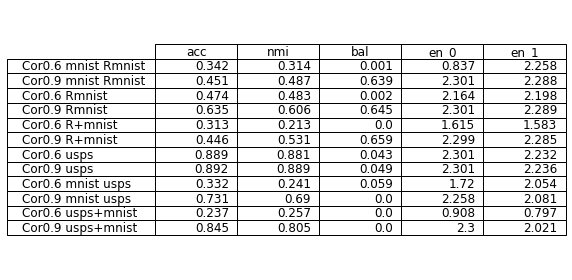

In [52]:
import matplotlib.pyplot as plt
def table_maker(results,names):
    measures = ["acc","nmi","bal","en_0","en_1"]
    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    t = ax.table(cellText=results,
              rowLabels=names,
              colLabels=measures, loc='center')
    #scaling to make the table bigger and nicer
    t.auto_set_font_size(False)
    t.set_fontsize(12)
    #t.auto_set_column_width(col=list(range(len(measures))))
    fig.tight_layout()
    plt.show()
table_results = []
for i in range(len(results)):
    table_results += [[round(float(num), 3) for num in results[i]]]

table_maker(table_results,["Cor0.6 mnist Rmnist","Cor0.9 mnist Rmnist","Cor0.6 Rmnist","Cor0.9 Rmnist", \
                     "Cor0.6 R+mnist","Cor0.9 R+mnist","Cor0.6 usps","Cor0.9 usps", \
                     "Cor0.6 mnist usps","Cor0.9 mnist usps","Cor0.6 usps+mnist","Cor0.9 usps+mnist"])